In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt


In [13]:
DATASET_PATH = "Levir-CD/"  # <------------------this
TRAIN_IMG1_DIR = os.path.join(DATASET_PATH, 'train/A/A')
TRAIN_IMG2_DIR = os.path.join(DATASET_PATH, 'train/B/B')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train/L/label')

VAL_IMG1_DIR = os.path.join(DATASET_PATH, 'val/A/A')
VAL_IMG2_DIR = os.path.join(DATASET_PATH, 'val/B/B')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val/L/label')

TEST_IMG1_DIR = os.path.join(DATASET_PATH, 'test/A/A')
TEST_IMG2_DIR = os.path.join(DATASET_PATH, 'test/B/B')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test/L/label')

In [14]:
IMG_SIZE = 256
BATCH_SIZE = 8 # <--------------------this


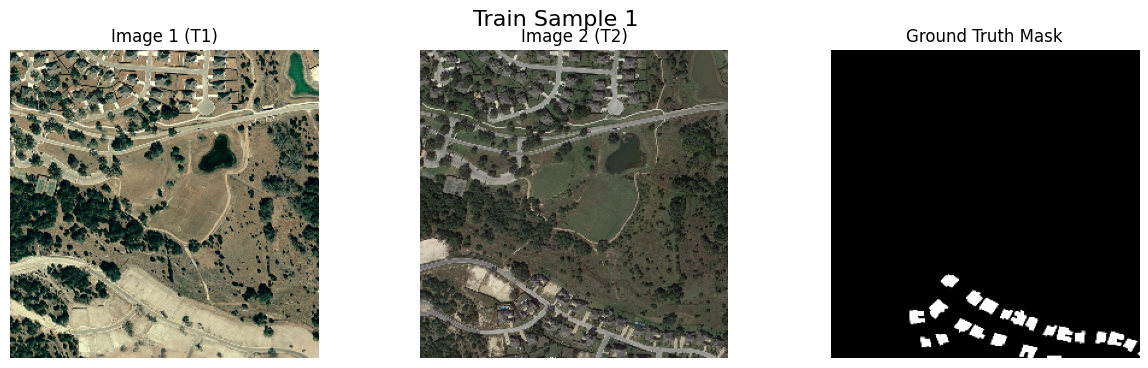

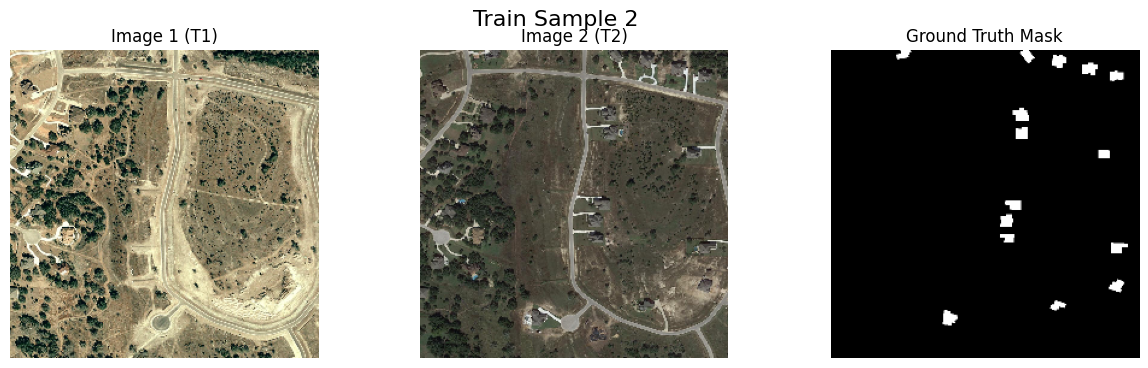

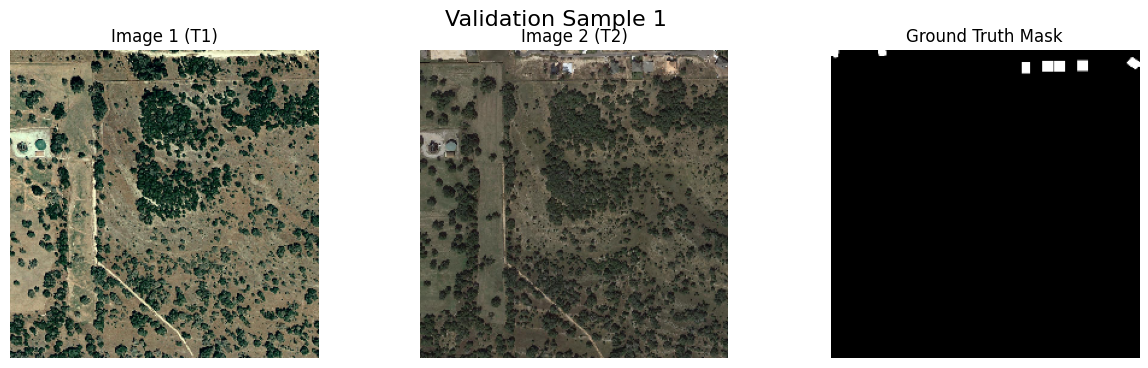

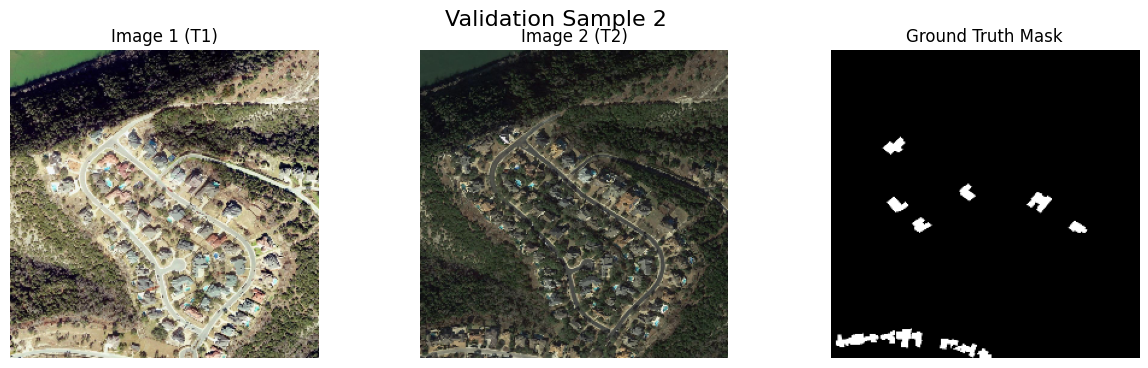

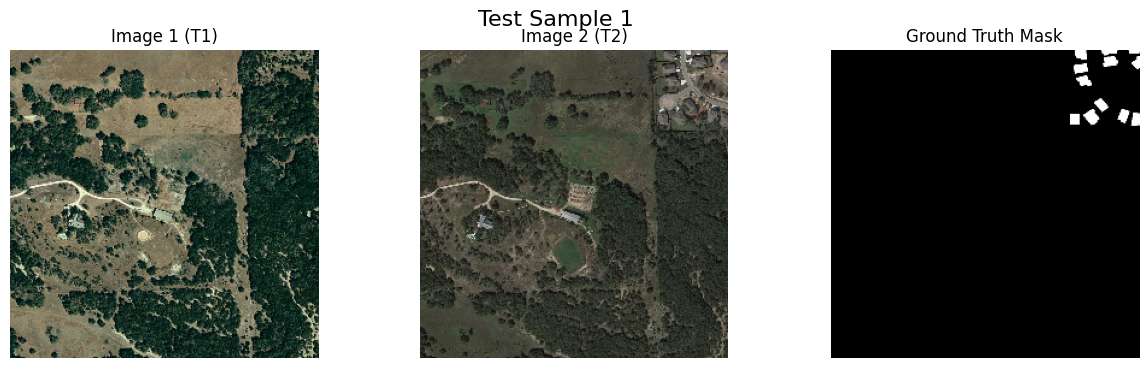

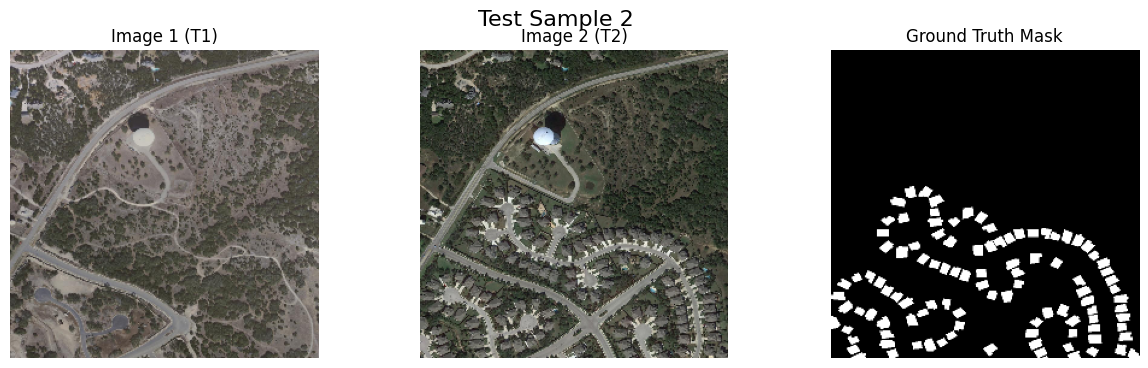

In [15]:
import matplotlib.pyplot as plt

def visualize_sample_pairs(img1_dir, img2_dir, mask_dir, title):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))])

    for i in range(2):
        img1 = cv2.imread(img1_files[i])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))

        img2 = cv2.imread(img2_files[i])
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

        mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"{title} Sample {i+1}", fontsize=16)

        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.title("Image 1 (T1)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img2)
        plt.title("Image 2 (T2)")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.show()

visualize_sample_pairs(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR, "Train")
visualize_sample_pairs(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR, "Validation")
visualize_sample_pairs(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR, "Test")


In [ ]:
def get_file_lists(img1_dir, img2_dir, mask_dir):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    return img1_files, img2_files, mask_files

train_imgs1, train_imgs2, train_masks = get_file_lists(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR)
val_imgs1, val_imgs2, val_masks = get_file_lists(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR)
test_imgs1, test_imgs2, test_masks = get_file_lists(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR)

print(f"Train: {len(train_imgs1)} pairs")
print(f"Val  : {len(val_imgs1)} pairs")
print(f"Test : {len(test_imgs1)} pairs")

Train: 445 pairs
Val  : 64 pairs
Test : 128 pairs


In [17]:
def load_pair_numpy(img1_path, img2_path, mask_path):
    img1 = cv2.imread(img1_path.decode(), cv2.IMREAD_COLOR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE)) / 255.0

    img2 = cv2.imread(img2_path.decode(), cv2.IMREAD_COLOR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE)) / 255.0

    mask = cv2.imread(mask_path.decode(), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img1.astype(np.float32), img2.astype(np.float32), mask

def load_pair_tf(img1_path, img2_path, mask_path):
    img1, img2, mask = tf.numpy_function(load_pair_numpy, [img1_path, img2_path, mask_path],
                                         [tf.float32, tf.float32, tf.float32])
    img1.set_shape([IMG_SIZE, IMG_SIZE, 3])
    img2.set_shape([IMG_SIZE, IMG_SIZE, 3])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return (img1, img2), mask


In [18]:
def create_dataset(img1_list, img2_list, mask_list, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((img1_list, img2_list, mask_list))
    ds = ds.map(load_pair_tf, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_imgs1, train_imgs2, train_masks, shuffle=True)
val_ds = create_dataset(val_imgs1, val_imgs2, val_masks)
test_ds = create_dataset(test_imgs1, test_imgs2, test_masks)


In [19]:
def fc_siam_diff_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    input_1 = layers.Input(input_size)
    input_2 = layers.Input(input_size)

    def encoder(x):
        c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
        p1 = layers.MaxPooling2D((2, 2))(c1)

        c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
        p2 = layers.MaxPooling2D((2, 2))(c2)

        c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
        p3 = layers.MaxPooling2D((2, 2))(c3)

        c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
        p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
        c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

        return c1, c2, c3, c4, c5

    c1_1, c2_1, c3_1, c4_1, c5_1 = encoder(input_1)
    c1_2, c2_2, c3_2, c4_2, c5_2 = encoder(input_2)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5_1)
    skip4_diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([c4_1, c4_2])
    u6 = layers.concatenate([u6, skip4_diff])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    skip3_diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([c3_1, c3_2])
    u7 = layers.concatenate([u7, skip3_diff])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    skip2_diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([c2_1, c2_2])
    u8 = layers.concatenate([u8, skip2_diff])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    skip1_diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([c1_1, c1_2])
    u9 = layers.concatenate([u9, skip1_diff])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[input_1, input_2], outputs=[outputs])
    return model

model = fc_siam_diff_model()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_29[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_30[0][0]                  
____________________________________________________________________________________________

In [20]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def precision_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    predicted_positives = tf.reduce_sum(y_pred_bin)
    precision = (true_positives + smooth) / (predicted_positives + smooth)
    return precision

def recall_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    actual_positives = tf.reduce_sum(y_true)
    recall = (true_positives + smooth) / (actual_positives + smooth)
    return recall

def f1_metric(y_true, y_pred, smooth=1e-6):
    prec = precision_metric(y_true, y_pred, smooth)
    rec = recall_metric(y_true, y_pred, smooth)
    return 2 * (prec * rec) / (prec + rec + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        iou_metric,
        precision_metric,
        recall_metric,
        f1_metric
    ]
)

print("done")

done


Epoch 1/15
56/56 [==============================] - 114s 1s/step - loss: 1.2675 - accuracy: 0.9190 - iou_metric: 0.0039 - precision_metric: 0.8655 - recall_metric: 0.0397 - f1_metric: 0.0073 - val_loss: 1.1659 - val_accuracy: 0.9567 - val_iou_metric: 5.0106e-11 - val_precision_metric: 1.0000 - val_recall_metric: 5.0106e-11 - val_f1_metric: 1.0021e-10

Epoch 00001: val_f1_metric improved from -inf to 0.00000, saving model to best_fc_ef_cd.h5
Epoch 2/15
56/56 [==============================] - 67s 1s/step - loss: 1.1482 - accuracy: 0.9527 - iou_metric: 5.3410e-11 - precision_metric: 1.0000 - recall_metric: 5.3410e-11 - f1_metric: 1.0682e-10 - val_loss: 1.0610 - val_accuracy: 0.9567 - val_iou_metric: 5.0106e-11 - val_precision_metric: 1.0000 - val_recall_metric: 5.0106e-11 - val_f1_metric: 1.0021e-10

Epoch 00002: val_f1_metric did not improve from 0.00000
Epoch 3/15
56/56 [==============================] - 68s 1s/step - loss: 0.9519 - accuracy: 0.9403 - iou_metric: 0.0595 - precision_met

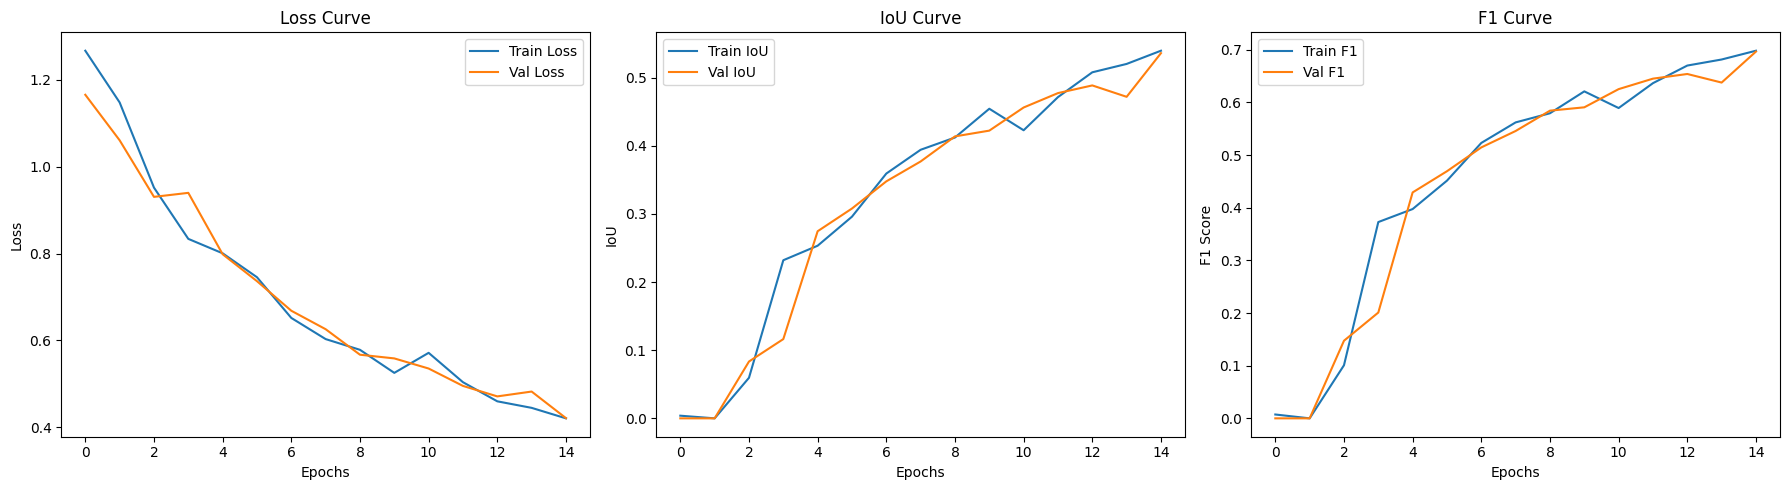

Training complete


In [ ]:

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'best_fc_ef_cd.h5',
    monitor='val_f1_metric',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_metric',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    verbose=1
)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['f1_metric'], label='Train F1')
plt.plot(history.history['val_f1_metric'], label='Val F1')
plt.title('F1 Curve')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print("Training complete")

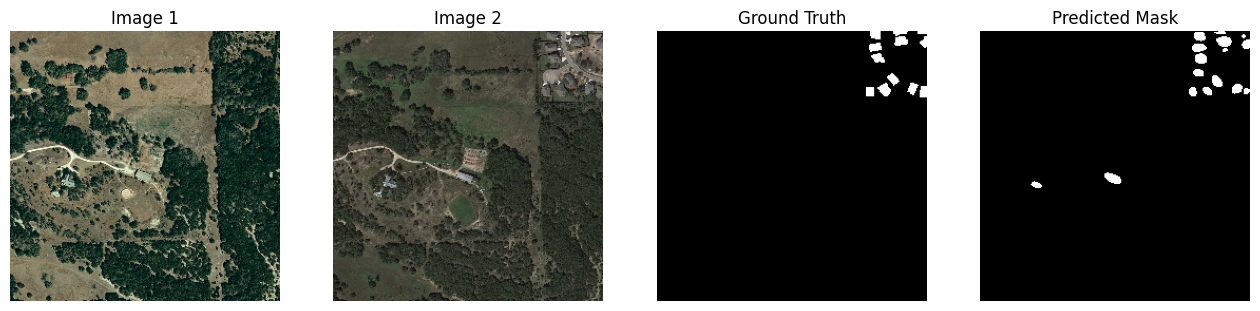

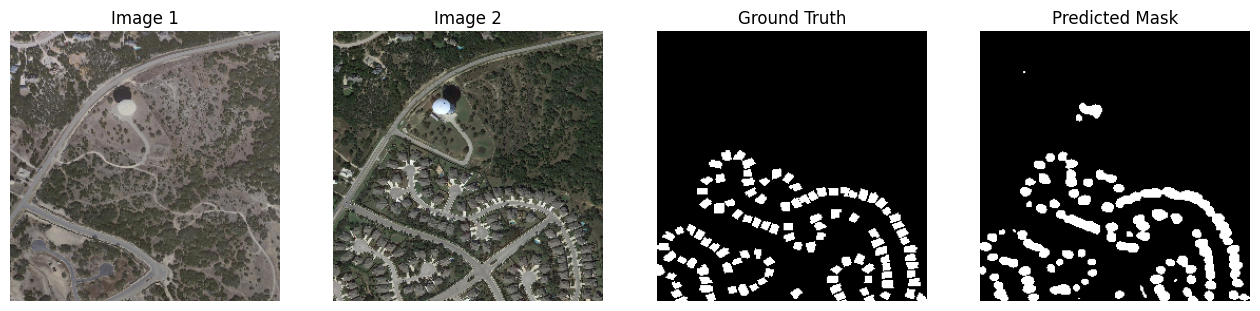

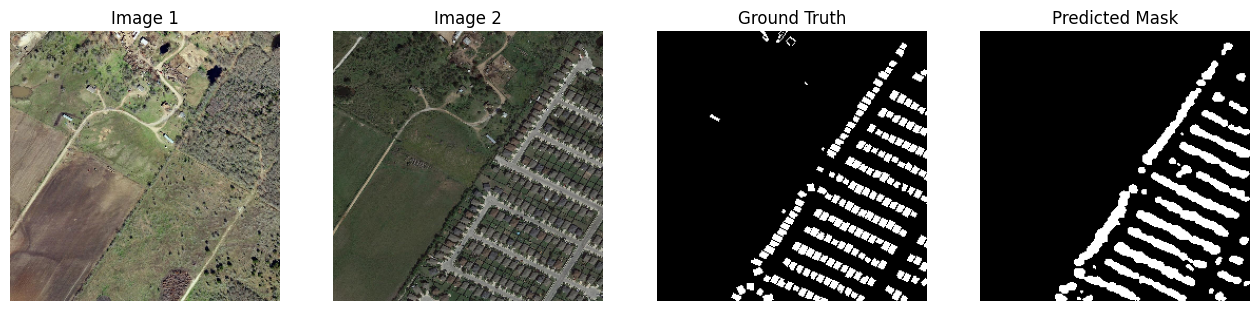

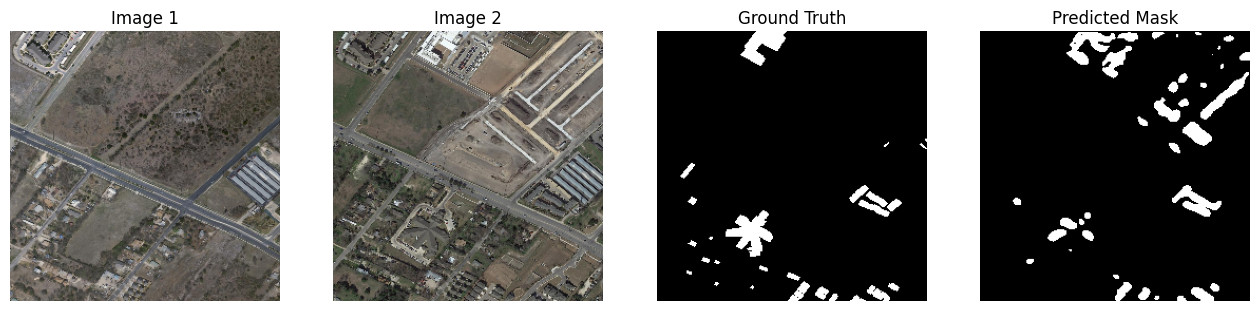

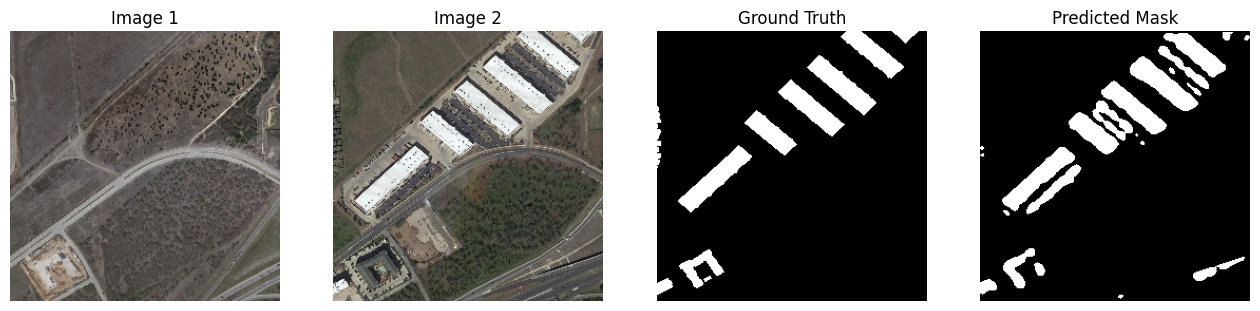

In [24]:
def visualize_predictions_grid(dataset, num_samples=5):
    import matplotlib.pyplot as plt
    import tensorflow as tf

    for imgs, masks in dataset.take(1):
        # imgs is a tuple of two tensors, each of shape (batch_size, IMG_SIZE, IMG_SIZE, 3)
        img1_batch, img2_batch = imgs
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        num_samples_to_show = min(num_samples, tf.shape(img1_batch)[0])

        for i in range(num_samples_to_show):
            plt.figure(figsize=(16, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(tf.cast(img1_batch[i], tf.float32), vmin=0, vmax=1)
            plt.title("Image 1")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(tf.cast(img2_batch[i], tf.float32), vmin=0, vmax=1)
            plt.title("Image 2")
            plt.axis('off')

            # Ground Truth
            plt.subplot(1, 4, 3)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 4, 4)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_predictions_grid(test_ds, num_samples=5)

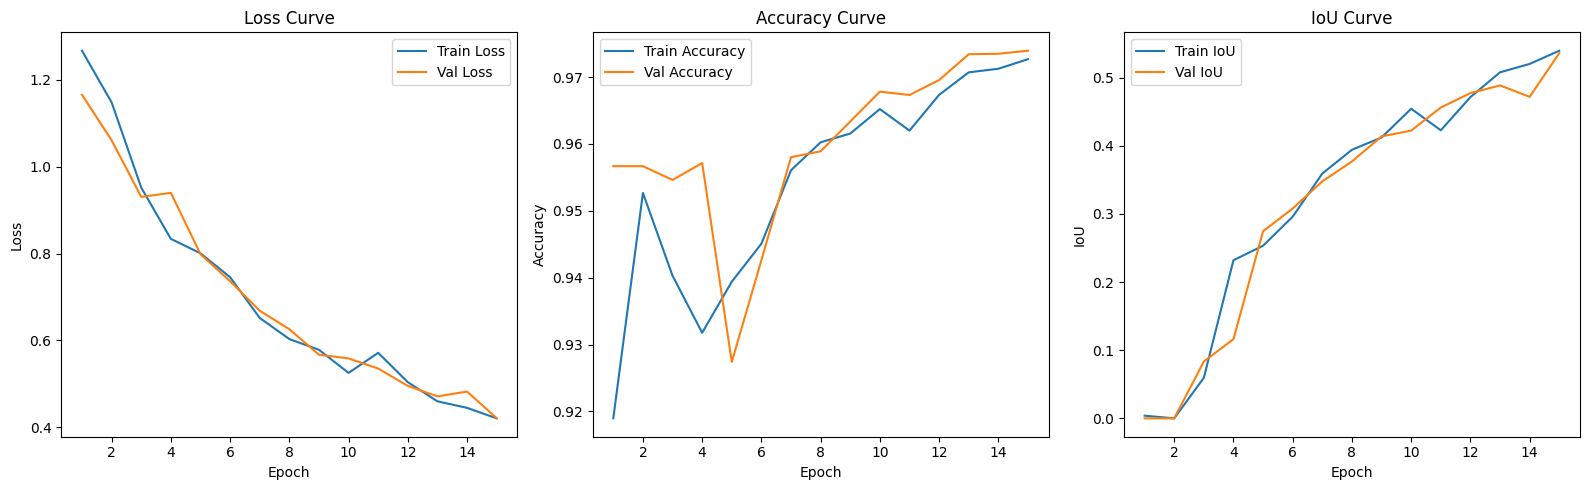

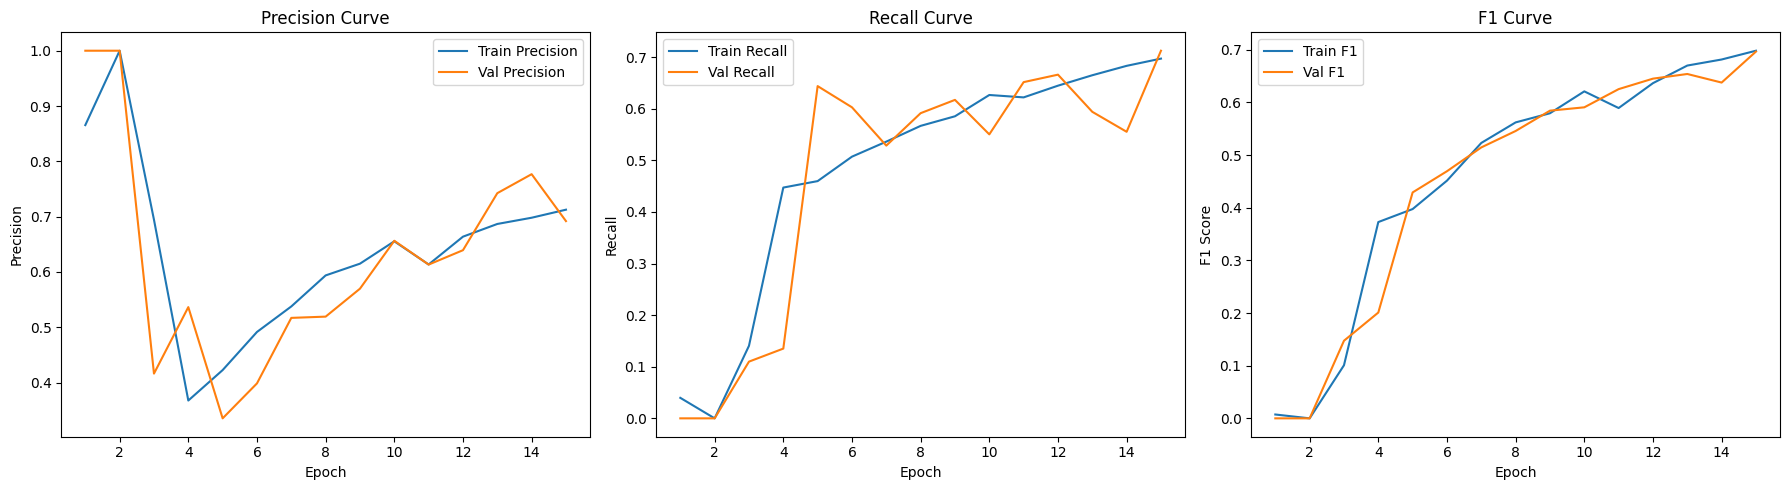

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Train IoU')
plt.plot(epochs, val_iou, label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.title('Precision Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, recall, label='Train Recall')
plt.plot(epochs, val_recall, label='Val Recall')
plt.title('Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, f1, label='Train F1')
plt.plot(epochs, val_f1, label='Val F1')
plt.title('F1 Curve')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

epochs = range(1, len(loss) + 1)
print(" Final Training Metrics:")

print(f" Final Train Loss: {loss[-1]:.4f}")
print(f" Final Val Loss  : {val_loss[-1]:.4f}\n")

print(f" Final Train Accuracy: {accuracy[-1]:.4f}")
print(f" Final Val Accuracy  : {val_accuracy[-1]:.4f}\n")

print(f" Final Train IoU: {iou[-1]:.4f}")
print(f" Final Val IoU  : {val_iou[-1]:.4f}\n")

print(f" Final Train Precision: {precision[-1]:.4f}")
print(f" Final Val Precision  : {val_precision[-1]:.4f}\n")

print(f" Final Train Recall: {recall[-1]:.4f}")
print(f" Final Val Recall  : {val_recall[-1]:.4f}\n")

print(f" Final Train F1 Score: {f1[-1]:.4f}")
print(f" Final Val F1 Score  : {val_f1[-1]:.4f}")



 Final Training Metrics:
 Final Train Loss: 0.4201
 Final Val Loss  : 0.4206

 Final Train Accuracy: 0.9727
 Final Val Accuracy  : 0.9739

 Final Train IoU: 0.5396
 Final Val IoU  : 0.5361

 Final Train Precision: 0.7126
 Final Val Precision  : 0.6920

 Final Train Recall: 0.6970
 Final Val Recall  : 0.7123

 Final Train F1 Score: 0.6982
 Final Val F1 Score  : 0.6966


In [27]:
additional_epochs = 35

history_additional = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1] + additional_epochs + 1,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[ checkpoint_cb, early_stop_cb, reduce_lr_cb],
    verbose=1
)

Epoch 16/50
56/56 [==============================] - 63s 1s/step - loss: 0.4039 - accuracy: 0.9738 - iou_metric: 0.5546 - precision_metric: 0.7233 - recall_metric: 0.7096 - f1_metric: 0.7109 - val_loss: 0.4565 - val_accuracy: 0.9750 - val_iou_metric: 0.4967 - val_precision_metric: 0.8134 - val_recall_metric: 0.5652 - val_f1_metric: 0.6600

Epoch 00016: val_f1_metric did not improve from 0.69659
Epoch 17/50
56/56 [==============================] - 68s 1s/step - loss: 0.4045 - accuracy: 0.9737 - iou_metric: 0.5543 - precision_metric: 0.7268 - recall_metric: 0.7112 - f1_metric: 0.7106 - val_loss: 0.3956 - val_accuracy: 0.9770 - val_iou_metric: 0.5540 - val_precision_metric: 0.7618 - val_recall_metric: 0.6750 - val_f1_metric: 0.7111

Epoch 00017: val_f1_metric improved from 0.69659 to 0.71110, saving model to best_fc_ef_cd.h5
Epoch 18/50
56/56 [==============================] - 67s 1s/step - loss: 0.4056 - accuracy: 0.9735 - iou_metric: 0.5522 - precision_metric: 0.7252 - recall_metric: 0.

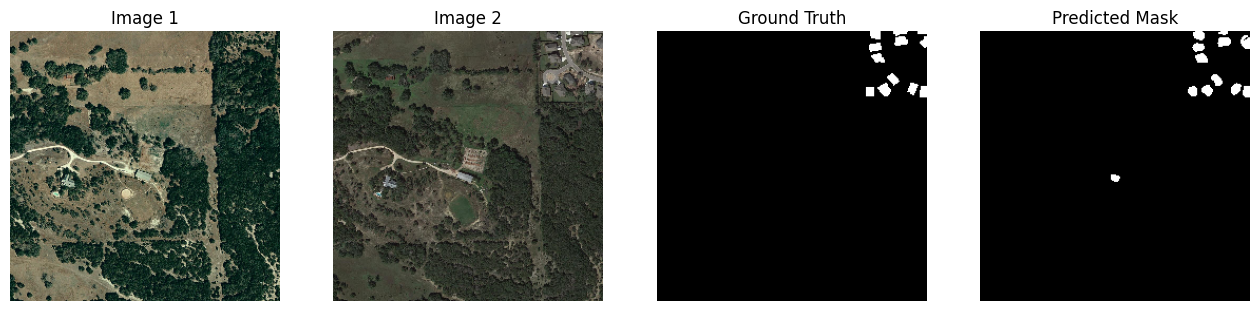

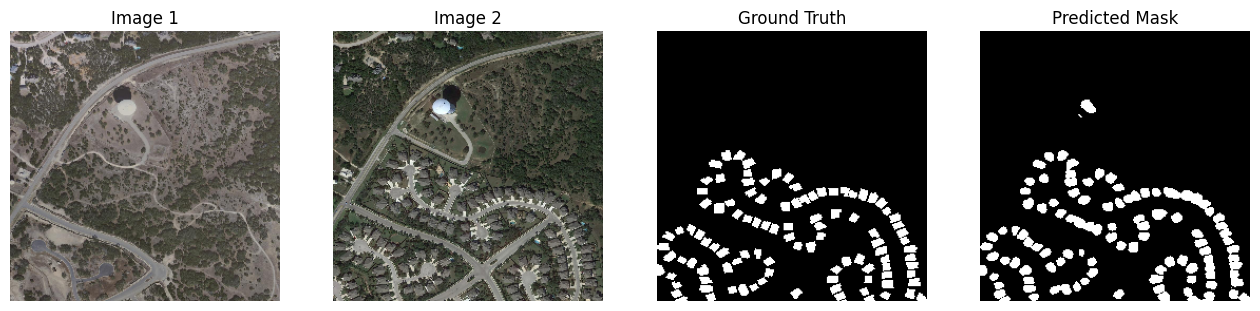

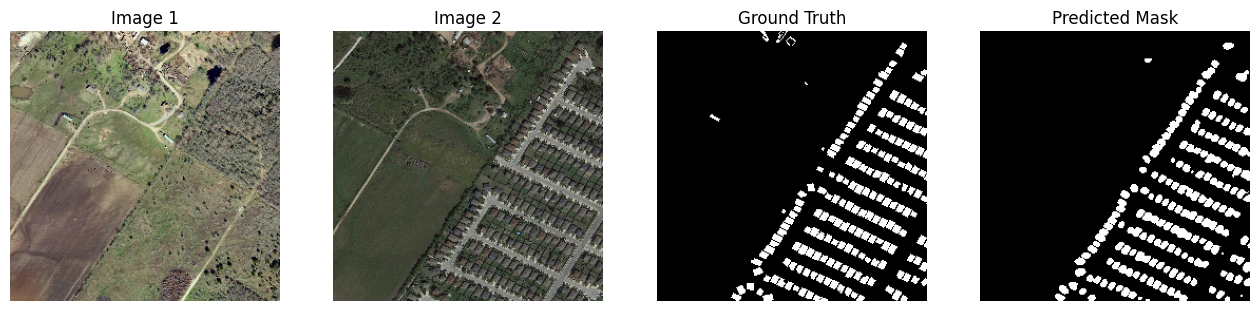

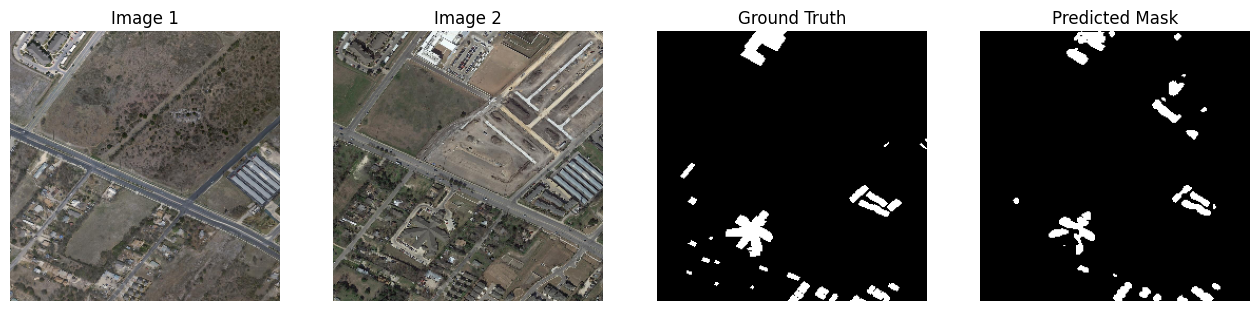

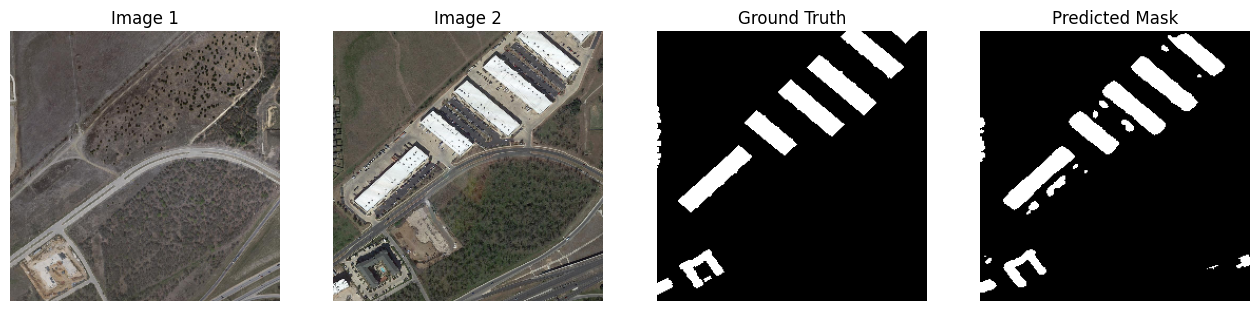

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions_grid(dataset, num_samples=5):
    for imgs, masks in dataset.take(1):
        img1_batch, img2_batch = imgs
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        num_samples_to_show = min(num_samples, tf.shape(img1_batch)[0])

        for i in range(num_samples_to_show):
            plt.figure(figsize=(16, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(tf.cast(img1_batch[i], tf.float32), vmin=0, vmax=1)
            plt.title("Image 1")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(tf.cast(img2_batch[i], tf.float32), vmin=0, vmax=1)
            plt.title("Image 2")
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_predictions_grid(test_ds, num_samples=5)
